In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")

In [137]:
symbol = "EUR_USD_Ask"
start = "2017-01-01"
end = "2021-12-31"
tc = 0.000059
granularity = '1h'

In [107]:
def get_data():
    raw = pd.read_csv("EUR_USD.csv", parse_dates = ["time"], index_col = "time", usecols=[0,1])
    raw = raw["EUR_USD_Ask"].to_frame().dropna() 
    raw = raw.loc[f'{start} 00:00:00': f'{end} 23:59:00'].copy()
    raw.rename(columns={"EUR_USD_Ask": "price"}, inplace=True)
    raw = raw.resample(granularity, label='right').last().ffill().iloc[:-1]
    raw["returns"] = np.log(raw / raw.shift(1))
    data = raw
    return data

In [108]:
dataset = get_data()

In [109]:
class SMABacktester():

    def __init__(self, dataset, SMA_S, SMA_L, tc):
        self.dataset = dataset
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.results = None
        self.tc = tc

        self.prepare_data()

    def prepare_data(self):
        data = self.dataset.copy()
        data["SMA_S"] = data["price"].rolling(self.SMA_S).mean() # add short sma
        data["SMA_L"] = data["price"].rolling(self.SMA_L).mean()
        self.data = data
    
    def test_strategy(self):
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)

        # vriskw arithmo trades
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy - data.trades * self.tc

        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance
        outperf = perf - data["creturns"].iloc[-1] # outperformance 
        return round(perf, 6), round(outperf, 6)

In [110]:
class MeanRevBacktester():

    def __init__(self, dataset, SMA, dev, tc):

        self.dataset = dataset
        self.SMA = SMA
        self.dev = dev
        self.results = None
        self.tc = tc

        self.prepare_data()

    def prepare_data(self):
        data = self.dataset.copy()
        data["SMA"] = data["price"].rolling(self.SMA).mean()
        data["Lower"] = data["SMA"] - data["price"].rolling(self.SMA).std() * self.dev
        data["Upper"] = data["SMA"] + data["price"].rolling(self.SMA).std() * self.dev
        self.data = data

    def test_strategy(self):

        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower, 1, np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)

In [111]:
class ConBacktester():
 
    
    def __init__(self, dataset, tc):

        self.dataset = dataset
        self.tc = tc
        self.results = None

    def test_strategy(self, window = 1):

        self.window = window
        data = self.dataset.copy().dropna()
        data["position"] = -np.sign(data["returns"].rolling(self.window).mean())
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)

In [112]:
from statsmodels.tsa.arima.model import ARIMA

Ar_data = dataset.copy()
ARIMA_model = ARIMA(Ar_data['price'], order=(1,1,0))
model_fit = ARIMA_model.fit()
Ar_data['ARIMA_forecast'] = model_fit.predict()
Ar_data['ARIMA_returns'] = Ar_data['ARIMA_forecast'] - Ar_data['price'].shift(1)
Ar_data.dropna(inplace=True)
Ar_data["ARIMA_position"] = np.sign(Ar_data['ARIMA_returns'])


In [113]:
import pickle

model = pickle.load(open('logreg.pkl', "rb"))

ML_data = dataset.copy()

ML_data["ML_returns"] = np.log(ML_data['price'] / ML_data['price'].shift())
cols = []
lags = 5
for lag in range(1, lags + 1):
    col = "lag{}".format(lag)
    ML_data[col] = ML_data['ML_returns'].shift(lag)
    cols.append(col)
ML_data.dropna(inplace = True)
ML_data["ML_position"] = model.predict(ML_data[cols])

c:\Users\Nikos\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [114]:
def optimal_strategy(dataset, parameters, arima_df, ml_df):
    
    dataset = dataset

    tc = 0.000059
    
    
    # SMA
    tester1 = SMABacktester(dataset, int(parameters[0]), int(parameters[1]), tc)
    tester1.test_strategy()
    
    # Bollinger
    tester2 = MeanRevBacktester(dataset,  int(parameters[2]),  int(parameters[3]), tc)
    tester2.test_strategy()
    
    # Contrarian
    tester3 = ConBacktester(dataset, tc)
    tester3.test_strategy(window=5)

    # Create comb
    comb = tester1.results.loc[:, ["returns", "position"]].copy()
    comb.rename(columns = {"position":"position_SMA"}, inplace = True)
    
    comb["position_MR"] = tester2.results.position

    comb["position_Cont"] = tester3.results.position

    comb["ARIMA_position"] = arima_df.ARIMA_position

    comb["ML_position"] = ml_df.ML_position

    comb["position_comb"] = np.sign(comb.position_MR + comb.position_SMA + comb.position_Cont + comb.ARIMA_position + comb.ML_position) 
    
    comb["NYTime"] = comb.index.tz_convert("America/New_York")
    comb["hour"] = comb.NYTime.dt.hour
    comb.position_comb = np.where(comb.hour.between(2, 12), comb.position_comb, 0)
    
    comb["strategy"] = comb["position_comb"].shift(1) * comb["returns"]
    comb.dropna(inplace=True)
    comb["trades"] = comb.position_comb.diff().fillna(0).abs()
    comb.strategy = comb.strategy - comb.trades * tc
    comb["creturns"] = comb["returns"].cumsum().apply(np.exp)
    comb["cstrategy"] = comb["strategy"].cumsum().apply(np.exp)
    
    perf = comb["cstrategy"].iloc[-1] # absolute performance of the strategy
    outperf = perf - comb["creturns"].iloc[-1] # out-/underperformance of strategy

    return round(perf, 6), round(outperf, 6)

In [133]:
def fwd_strategy(dataset, parameters):
    
    dataset = dataset

    tc = 0.000059
    
    
    # SMA
    tester1 = SMABacktester(dataset, int(parameters[0]), int(parameters[1]), tc)
    tester1.test_strategy()
    
    # Bollinger
    tester2 = MeanRevBacktester(dataset,  int(parameters[2]),  int(parameters[3]), tc)
    tester2.test_strategy()
    
    # Contrarian
    tester3 = ConBacktester(dataset, tc)
    tester3.test_strategy(window=5)

    # Create comb
    comb = tester1.results.loc[:, ["returns", "position"]].copy()
    comb.rename(columns = {"position":"position_SMA"}, inplace = True)
    
    comb["position_MR"] = tester2.results.position

    comb["position_Cont"] = tester3.results.position

    Ar_data = dataset.copy()
    ARIMA_model = ARIMA(Ar_data['price'], order=(1,1,1))
    model_fit = ARIMA_model.fit()
    Ar_data['ARIMA_forecast'] = model_fit.predict()
    Ar_data['ARIMA_returns'] = Ar_data['ARIMA_forecast'] - Ar_data['price'].shift(1)
    Ar_data.dropna(inplace=True)
    Ar_data["ARIMA_position"] = np.sign(Ar_data['ARIMA_returns'])

    comb["ARIMA_position"] = Ar_data.ARIMA_position

    import pickle

    model = pickle.load(open('logreg.pkl', "rb"))

    ML_data = dataset.copy()

    ML_data["ML_returns"] = np.log(ML_data['price'] / ML_data['price'].shift())
    cols = []
    lags = 5
    for lag in range(1, lags + 1):
        col = "lag{}".format(lag)
        ML_data[col] = ML_data['ML_returns'].shift(lag)
        cols.append(col)
    ML_data.dropna(inplace = True)
    ML_data["ML_position"] = model.predict(ML_data[cols])


    comb["ML_position"] = ML_data.ML_position

    comb["position_comb"] = np.sign(comb.position_MR + comb.position_SMA + comb.position_Cont + comb.ARIMA_position + comb.ML_position) 
    
    comb["NYTime"] = comb.index.tz_convert("America/New_York")
    comb["hour"] = comb.NYTime.dt.hour
    comb.position_comb = np.where(comb.hour.between(2, 12), comb.position_comb, 0)
    
    comb["strategy"] = comb["position_comb"].shift(1) * comb["returns"]
    comb["trades"] = comb.position_comb.diff().fillna(0).abs()
    comb.dropna(inplace=True)

    comb["strategy_net"] = comb.strategy - comb.trades * tc
    comb["creturns"] = comb["returns"].cumsum().apply(np.exp)
    comb["cstrategy"] = comb["strategy"].cumsum().apply(np.exp)
    comb["cstrategy_net"] = comb["strategy_net"].cumsum().apply(np.exp)


    return comb

In [116]:
from itertools import product

SMA_S_range = (20, 30)
SMA_L_range = (180,200)
SMA_S_Bol = (25,35)
STDev = (1,2)
combinations = list(product(range(*SMA_S_range), range(*SMA_L_range), range(*SMA_S_Bol), range(*STDev)))

In [117]:
results=[]
for comb in combinations:
    #bc.test_sma_strategy(comb[0], comb[1])
    results.append(optimal_strategy(dataset, (comb[0], comb[1], comb[2],comb[3]), Ar_data, ML_data ))

In [120]:
best_perf = np.max(results) # best performance
opt = combinations[np.argmax(results[0])]
print(best_perf, opt)

0.736606 (20, 180, 25, 1)


In [136]:
symbol = "EUR_USD_Ask"
start = "2021-01-01"
end = "2021-12-31"
tc = 0.000059
granularity = '1h'

fwd_test = get_data()





In [138]:
df = fwd_strategy(fwd_test, (20, 180, 25,1))
df

c:\Users\Nikos\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


,returns,position_SMA,position_MR,position_Cont,ARIMA_position,ML_position,position_comb,NYTime,hour,strategy,trades,strategy_net,creturns,cstrategy,cstrategy_net
time,,,,,,,,,,,,,,,
2021-01-11 12:00:00+00:00,-0.000066,-1,1.0,1.0,-1.0,1.0,1.0,2021-01-11 07:00:00-05:00,7,-0.000066,0.0,-0.000066,0.999934,0.999934,0.999934
2021-01-11 13:00:00+00:00,-0.000041,-1,1.0,1.0,1.0,1.0,1.0,2021-01-11 08:00:00-05:00,8,-0.000041,0.0,-0.000041,0.999893,0.999893,0.999893
2021-01-11 14:00:00+00:00,-0.001744,-1,1.0,1.0,1.0,1.0,1.0,2021-01-11 09:00:00-05:00,9,-0.001744,0.0,-0.001744,0.998151,0.998151,0.998151
2021-01-11 15:00:00+00:00,-0.000585,-1,1.0,1.0,1.0,1.0,1.0,2021-01-11 10:00:00-05:00,10,-0.000585,0.0,-0.000585,0.997567,0.997567,0.997567
2021-01-11 16:00:00+00:00,0.001070,-1,1.0,1.0,1.0,1.0,1.0,2021-01-11 11:00:00-05:00,11,0.001070,0.0,0.001070,0.998636,0.998636,0.998636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 17:00:00+00:00,0.000607,1,-1.0,-1.0,-1.0,-1.0,-1.0,2021-12-31 12:00:00-05:00,12,-0.000607,0.0,-0.000607,0.935239,1.023270,0.903280
2021-12-31 18:00:00+00:00,0.000632,1,-1.0,-1.0,-1.0,-1.0,0.0,2021-12-31 13:00:00-05:00,13,-0.000632,1.0,-0.000691,0.935831,1.022623,0.902656
2021-12-31 19:00:00+00:00,-0.000141,1,-1.0,-1.0,-1.0,-1.0,0.0,2021-12-31 14:00:00-05:00,14,-0.000000,0.0,-0.000000,0.935699,1.022623,0.902656


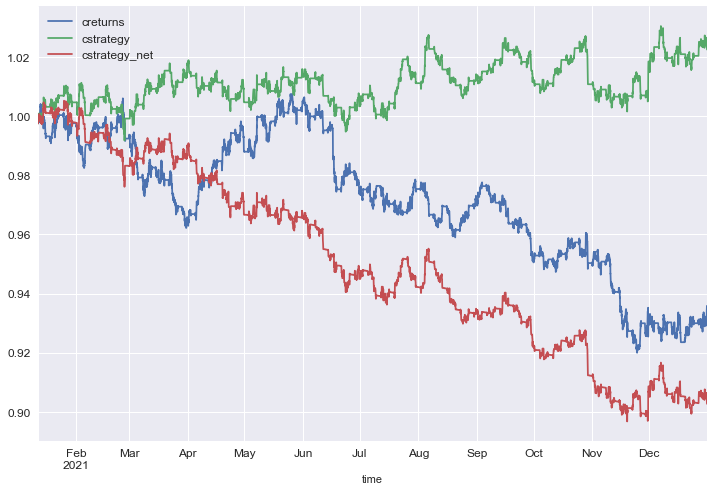

In [139]:
df[['creturns', 'cstrategy', 'cstrategy_net']].plot(figsize = (12,8), fontsize =12)
plt.legend(fontsize = 12)
plt.show()